# 🌍 Dynamic World

Choose a location for Vertex AI https://cloud.google.com/vertex-ai/docs/general/locations

ℹ️ Make sure the Cloud Storage bucket is in the same region https://cloud.google.com/storage/docs/locations (NOT MULTI REGION)

Create bucket: https://console.cloud.google.com/storage/create-bucket

In [ ]:
# !pip install -r https://raw.githubusercontent.com/GoogleCloudPlatform/python-docs-samples/main/people-and-planet-ai/land-cover-classification/requirements.txt

In [2]:
#@title My Google Cloud resources
project = "" #@param {type:"string"}
bucket = "" #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

# Load resources from environment variables if available
import os
project = os.environ.get('GOOGLE_CLOUD_PROJECT', project)
bucket = os.environ.get('CLOUD_STORAGE_BUCKET', bucket)
location = os.environ.get('CLOUD_LOCATION', location)

# Quick input validations
assert project, '⚠️ Please provide a Google Cloud project ID'
assert bucket, '⚠️ Please provide a Cloud Storage bucket name'
assert not bucket.startswith('gs://'), f'⚠️ Please remove the gs:// prefix from the bucket name: {bucket}'
assert location, '⚠️ Please provide a Google Cloud location'

# Authenticate
from google.colab import auth
auth.authenticate_user()

In [3]:
import google.auth
import ee

credentials, _ = google.auth.default()
ee.Initialize(credentials, project=project)

# Understand the data

- What is a land cover map?
- Why Sentinel 2 as inputs?
- Model input and output shapes

In [4]:
CLASSIFICATIONS = {
    '💧 Water':              '449cda',
    '🌳 Trees':              '3d7c49',
    '🌾 Grass':              '8ab052',
    '🌿 Flooded vegetation': '7c86c7',
    '🚜 Crops':              'e19832',
    '🪴 Shrub and scrub':    'dfc35b',
    '🏗️ Built-up areas':     'c52918',
    '🪨 Bare ground':        'a29d90',
    '❄️ Snow and ice':       'b4a0e0',
}
PALETTE = list(CLASSIFICATIONS.values())

def display_legend():
  reset_color = '\u001b[0m'
  colored = lambda red, green, blue: f"\033[48;2;{red};{green};{blue}m"
  for name, color in CLASSIFICATIONS.items():
    red   = int(color[0:2], 16)
    green = int(color[2:4], 16)
    blue  = int(color[4:6], 16)
    print(f"{colored(red, green, blue)}   {reset_color} {name}")

display_legend()

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


## **Input**: Sentinel 2 satellite images

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

Mask (hide) pixels covered by clouds or cirrus clouds.

TODO: explain how to mask clouds

In [ ]:
import folium

import export_data

sentinel2_image = export_data.get_sentinel2_image('2020-1-1', '2021-01-1')

vis_params = {
  'min': 0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2'],
}
folium.Map(
    location=[38.6561723, -9.0624997],
    zoom_start=12,
    tiles=sentinel2_image.getMapId(vis_params)['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

## **Output**: Land cover map

https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100

In [ ]:
import folium

import export_data

landcover_image = export_data.get_landcover_image()

vis_params = {
  'bands': ['landcover'],
  'palette': PALETTE,
}
folium.Map(
    location=[38.6561723, -9.0624997],
    zoom_start=12,
    tiles=landcover_image.getMapId(vis_params)['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

In [ ]:
display_legend()

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


# Create the datasets

In [ ]:
#@title
points_per_class = 10  #@param {type:"integer"}
padding = 15  #@param {type:"integer"}

# Load from environment variables if available
points_per_class = int(os.environ.get('POINTS_PER_CLASS', points_per_class))
padding = int(os.environ.get('PADDING', padding))

In [ ]:
import export_data

export_data.run(
    bucket=bucket,
    training_prefix="land-cover/training",
    validation_prefix="land-cover/validation",
    regions_file="regions-small.csv",
    points_per_class=points_per_class,
    padding=padding,
)

[Earth Engine tasks](https://code.earthengine.google.com/tasks)

# Train the model

In [ ]:
#@title ** train_model.py
%%writefile train_model.py
import tensorflow as tf
from typing import Dict, Tuple

INPUT_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
OUTPUT_BANDS = ['landcover']
NUM_CLASSIFICATIONS = 9

def read_dataset(filename: str, patch_size: int, batch_size: int) -> tf.data.Dataset:
  """Reads a compressed TFRecord dataset and preprocesses it into a machine
  learning friendly format."""
  input_shape = (patch_size, patch_size)
  features_dict = {
      band_name: tf.io.FixedLenFeature(input_shape, tf.float32)
      for band_name in INPUT_BANDS + OUTPUT_BANDS
  }
  return (
      tf.data.TFRecordDataset(filename, compression_type='GZIP')
      .map(lambda example_proto: tf.io.parse_single_example(example_proto, features_dict),
           num_parallel_calls=tf.data.AUTOTUNE)
      .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
      .cache()
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
  )

def preprocess(values: Dict[str, tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
  """Splits inputs and outputs into a tuple and converts the output
  classifications into one-hot encodings."""
  inputs = tf.stack([values[band] for band in INPUT_BANDS], axis=-1)
  outputs = tf.one_hot(tf.cast(values['landcover'], tf.uint8), NUM_CLASSIFICATIONS)
  return (inputs, outputs)

def new_model(training_dataset: tf.data.Dataset) -> tf.keras.Model:
  """Creates a new Fully Convolutional Network (FCN) model."""
  normalization = tf.keras.layers.Normalization()
  normalization.adapt(training_dataset.map(lambda x, _: x))

  model = tf.keras.Sequential([
      tf.keras.Input(shape=(None, None, len(INPUT_BANDS))),
      normalization,
      tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, activation='relu'),
      tf.keras.layers.Dense(NUM_CLASSIFICATIONS, activation='softmax'),
  ])
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'],
  )
  return model

def run(
    training_file: str,
    validation_file: str,
    save_model_to: str,
    epochs: int = 20,
    batch_size: int = 256,
    patch_size: int = 31,
) -> None:
  """Creates, trains and saves a new model."""
  training_dataset = read_dataset(training_file, patch_size, batch_size)
  validation_dataset = read_dataset(validation_file, patch_size, batch_size)

  model = new_model(training_dataset)
  model.fit(
      training_dataset.shuffle(10),
      validation_data=validation_dataset,
      epochs=epochs,
  )
  model.save(save_model_to)

if __name__ == '__main__':
  import argparse

  parser = argparse.ArgumentParser()
  parser.add_argument('--training-file', required=True)
  parser.add_argument('--validation-file', required=True)
  parser.add_argument('--save-model-to', required=True)
  parser.add_argument('--epochs', default=20, type=int)
  parser.add_argument('--batch-size', default=256, type=int)
  parser.add_argument('--patch-size', default=31, type=int)
  args = parser.parse_args()

  run(**vars(args))

Writing train_model.py


## Inspect the datasets

In [ ]:
!gsutil ls -lh gs://{bucket}/land-cover/*.tfrecord.gz

727.26 KiB  2022-04-04T22:54:42Z  gs://dcavazos-lyra/land-cover/training-10-15.tfrecord.gz
 22.05 MiB  2022-04-04T22:54:42Z  gs://dcavazos-lyra/land-cover/training-100-31.tfrecord.gz
 55.41 MiB  2022-04-04T22:54:41Z  gs://dcavazos-lyra/land-cover/training-1000-15.tfrecord.gz
825.03 MiB  2022-04-04T22:54:42Z  gs://dcavazos-lyra/land-cover/training-1000-63.tfrecord.gz
167.06 MiB  2022-04-04T22:54:42Z  gs://dcavazos-lyra/land-cover/training-3000-15.tfrecord.gz
277.26 MiB  2022-04-04T22:54:42Z  gs://dcavazos-lyra/land-cover/training-5000-15.tfrecord.gz
892.68 KiB  2022-04-06T00:00:46Z  gs://dcavazos-lyra/land-cover/training-test.tfrecord.gz
544.79 KiB  2022-04-05T21:47:42Z  gs://dcavazos-lyra/land-cover/training.tfrecord.gz
217.02 KiB  2022-04-04T22:54:42Z  gs://dcavazos-lyra/land-cover/validation-10-15.tfrecord.gz
  4.73 MiB  2022-04-04T22:54:42Z  gs://dcavazos-lyra/land-cover/validation-100-31.tfrecord.gz
 13.44 MiB  2022-04-04T22:54:42Z  gs://dcavazos-lyra/land-cover/validation-1000-15.

In [ ]:
import tensorflow as tf

filename = f"gs://{bucket}/land-cover/training.tfrecord.gz"
dataset = tf.data.TFRecordDataset(filename, compression_type='GZIP') 
for x in dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(x.numpy())
  for _, feature in example.ListFields():
    for _, field in feature.ListFields():
      for name, values in sorted(field.items()):
        print(f"{name}: float[{len(values.float_list.value)}]")

B1: float[961]
B10: float[961]
B11: float[961]
B12: float[961]
B2: float[961]
B3: float[961]
B4: float[961]
B5: float[961]
B6: float[961]
B7: float[961]
B8: float[961]
B8A: float[961]
B9: float[961]
landcover: float[961]


## Read the datasets

In [ ]:
padding = 15
patch_size = padding + 1 + padding

print(f"Padding: {padding}")
print(f"Patch size: {patch_size}")
print(f"Patch area: {patch_size * patch_size}")

Padding: 15
Patch size: 31
Patch area: 961


https://www.tensorflow.org/guide/data_performance

In [ ]:
import train_model

training_file = f"gs://{bucket}/land-cover/training.tfrecord.gz"
validation_file = f"gs://{bucket}/land-cover/validation.tfrecord.gz"
batch_size = 64

training_dataset = train_model.read_dataset(training_file, patch_size, batch_size)
validation_dataset = train_model.read_dataset(training_file, patch_size, batch_size)

for inputs, outputs in training_dataset.take(1):
  print('# Shapes')
  print(f"inputs:  {inputs.shape}")
  print(f"outputs: {outputs.shape}")
  print()
  print('# First element')
  print(f"input:  {inputs[0, 0, 0]}")
  print(f"output: {outputs[0, 0, 0]}")

# Shapes
inputs:  (50, 31, 31, 13)
outputs: (50, 31, 31, 9)

# First element
input:  [1823.  1183.5 1073.5  832.  1304.  2144.  2294.5 2354.5 2421.   941.
   16.5 1700.  1102. ]
output: [0. 0. 0. 0. 0. 0. 1. 0. 0.]


(batch_size, width, height, num_bands)

## Model architecture

TODO: add diagram

- https://keras.io/api/layers/core_layers/input/
- https://keras.io/api/layers/preprocessing_layers/numerical/normalization/
- https://keras.io/api/layers/convolution_layers/convolution2d/
- https://keras.io/api/layers/convolution_layers/convolution2d_transpose/
- https://keras.io/api/layers/core_layers/dense/
- https://keras.io/api/optimizers/
- https://keras.io/api/losses/

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, None, 13)   27        
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    10432     
                                                                 
 conv2d_transpose (Conv2DTra  (None, None, None, 16)   12816     
 nspose)                                                         
                                                                 
 dense (Dense)               (None, None, None, 9)     153       
                                                                 
Total params: 23,428
Trainable params: 23,401
Non-trainable params: 27
_________________________________________________________________


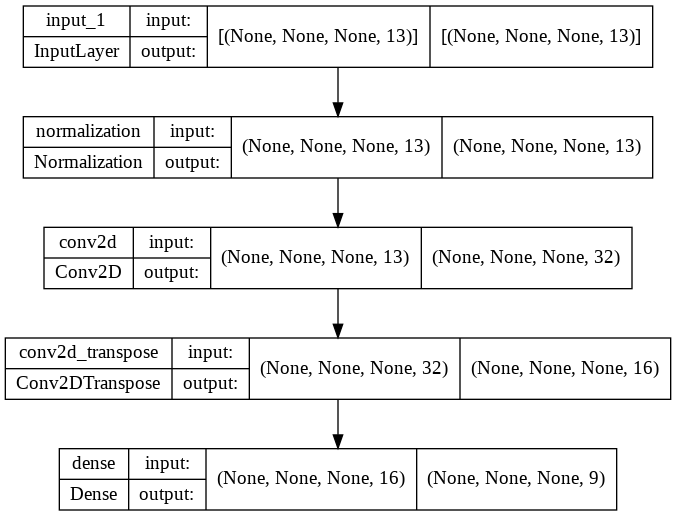

In [ ]:
import tensorflow as tf
import train_model

model = train_model.new_model(training_dataset)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

## Fit the model

In [ ]:
model.fit(
    training_dataset.shuffle(10),
    validation_data=validation_dataset,
    epochs=10,
)
model.save('local-model')

Epoch 1/3
1/1 [==============================] - 0s 451ms/step - loss: 1.2102 - accuracy: 0.5841 - val_loss: 1.1681 - val_accuracy: 0.5894
Epoch 2/3
1/1 [==============================] - 0s 346ms/step - loss: 1.1681 - accuracy: 0.5894 - val_loss: 1.1512 - val_accuracy: 0.5901
Epoch 3/3
1/1 [==============================] - 0s 355ms/step - loss: 1.1512 - accuracy: 0.5901 - val_loss: 1.1526 - val_accuracy: 0.5897
INFO:tensorflow:Assets written to: local-model/assets


# Get predictions

## Fetch input data

https://en.wikipedia.org/wiki/Camp_Fire_(2018)

In [ ]:
import ee
import numpy as np
import multiprocessing

import export_data

lat, lon = 39.78184333760811, -121.51241667728155

def get_prediction_patch(date_range: tuple, padding=255) -> np.ndarray:
  start_date, end_date = date_range
  image = export_data.get_sentinel2_image(start_date, end_date).select(export_data.INPUT_BANDS)
  point = ee.Feature(ee.Geometry.Point([lon, lat]))
  patch = export_data.get_patch(point, image, padding)
  band_values = patch.getInfo()['properties']
  return np.stack([band_values[band] for band in export_data.INPUT_BANDS], axis=-1)

dates = [
    ('2017-01-01', '2017-12-31'),
    ('2018-01-01', '2018-12-31'),  # 🔥 in November
    ('2019-01-01', '2019-12-31'),
    ('2020-01-01', '2020-12-31'),
    ('2021-01-01', '2021-12-31'),
]
with multiprocessing.Pool(len(dates)) as pool:
  input_batch = np.flip(pool.map(get_prediction_patch, dates), axis=1)
print(f"input_batch: {input_batch.dtype} {input_batch.shape}")

input_batch: float64 (5, 511, 511, 13)


## Visualize inputs

sentinel2 images: uint8 (5, 511, 511, 3)


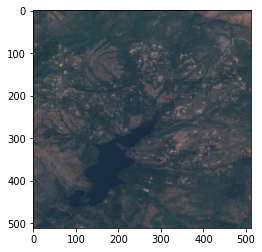

In [ ]:
import matplotlib.pyplot as plt

def render_rgb_images(values: np.ndarray, min=0.0, max=1.0, gamma=1.0) -> np.ndarray:
  scaled_values = (values - min) / (max - min)
  gamma_corrected_values = scaled_values ** (1.0 / gamma)
  rgb_values = gamma_corrected_values * 255
  return rgb_values.astype(np.uint8)

def render_sentinel2(input_batch: np.ndarray) -> np.ndarray:
  red   = input_batch[..., 3]  # B4
  green = input_batch[..., 2]  # B3
  blue  = input_batch[..., 1]  # B2
  rgb_input_batch = np.stack([red, green, blue], axis=-1)
  return render_rgb_images(rgb_input_batch, max=3000)

sentinel2_images = render_sentinel2(input_batch)
print(f"sentinel2 images: {sentinel2_images.dtype} {sentinel2_images.shape}")

# Show one of the images to see how the Landsat input images look like.
plt.imshow(sentinel2_images[0])
plt.show()

## Model prediction

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(f"local-model")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, None, 13)   27        
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    10432     
                                                                 
 conv2d_transpose (Conv2DTra  (None, None, None, 16)   12816     
 nspose)                                                         
                                                                 
 dense (Dense)               (None, None, None, 9)     153       
                                                                 
Total params: 23,428
Trainable params: 23,401
Non-trainable params: 27
_________________________________________________________________


In [ ]:
probabilities = model.predict(input_batch)
print(f"probabilities: {probabilities.dtype} {probabilities.shape}")

probabilities: float32 (5, 511, 511, 9)


## Visualize outputs

landcover images: uint8 (5, 511, 511, 3)


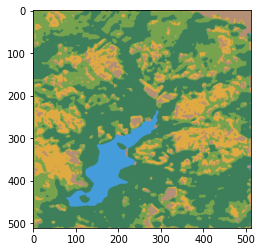

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


In [ ]:
def render_classifications(probabilities: np.ndarray, palette: list) -> np.ndarray:
  # Create a color map from a hex color palette.
  xs = np.linspace(0, len(palette) - 1, 256)
  indices = np.arange(len(palette))
  color_map = np.array([
        np.interp(xs, indices, [int(c[0:2], 16) for c in palette]),  # reds
        np.interp(xs, indices, [int(c[2:4], 16) for c in palette]),  # greens
        np.interp(xs, indices, [int(c[4:6], 16) for c in palette]),  # blues
  ]).astype(np.uint8).transpose()

  # Convert the probabilities into prediction indices and map them to the color map.
  predictions = np.argmax(probabilities, axis=-1)
  color_indices = (predictions / len(CLASSIFICATIONS) * 255).astype(np.uint8)
  return np.take(color_map, color_indices, axis=0)

def render_landcover(probabilities: np.ndarray) -> np.ndarray:
  palette = list(CLASSIFICATIONS.values())
  return render_classifications(probabilities, palette)

# Render all our model probability predictions into RGB images.
landcover_images = render_landcover(probabilities)
print(f"landcover images: {landcover_images.dtype} {landcover_images.shape}")

# Show one of the images to see how the land cover predictions look like.
plt.imshow(landcover_images[0])
plt.show()

display_legend()

## Land cover change

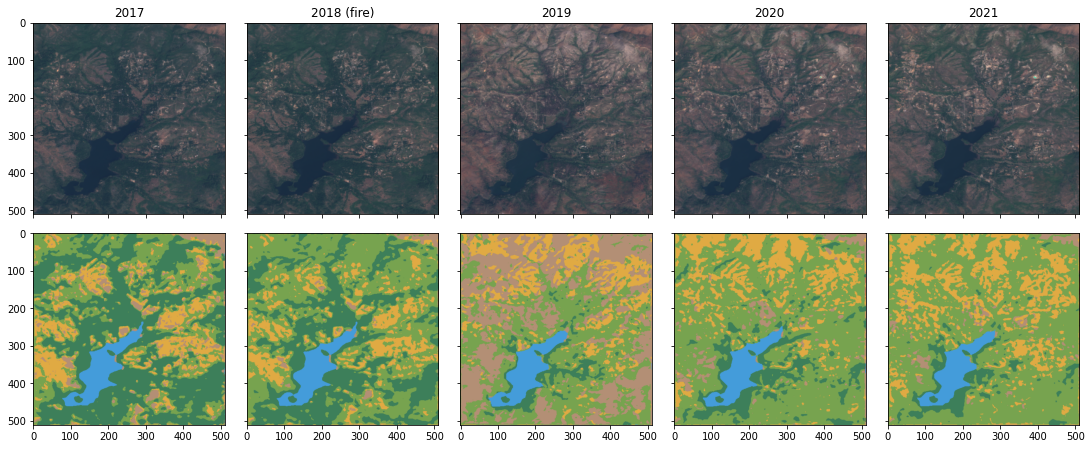

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


In [ ]:
def display_land_cover_change(sentinel2_images: np.ndarray, landcover_images: np.ndarray):
  img_size = 3
  figsize = (img_size * len(dates), img_size * 2)
  figure, plot_rows = plt.subplots(2, len(dates), figsize=figsize, sharex=True, sharey=True)
  figure.tight_layout(pad=0)

  titles = [date[:4] for date, _ in dates]
  for title, plot, image in zip(titles, plot_rows[0], sentinel2_images):
    plot.set_title(title if title != '2018' else '2018 (fire)')
    plot.imshow(image)
  for plot, image in zip(plot_rows[1], landcover_images):
    plot.imshow(image)
  plt.show()

  display_legend()

display_land_cover_change(sentinel2_images, landcover_images)

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


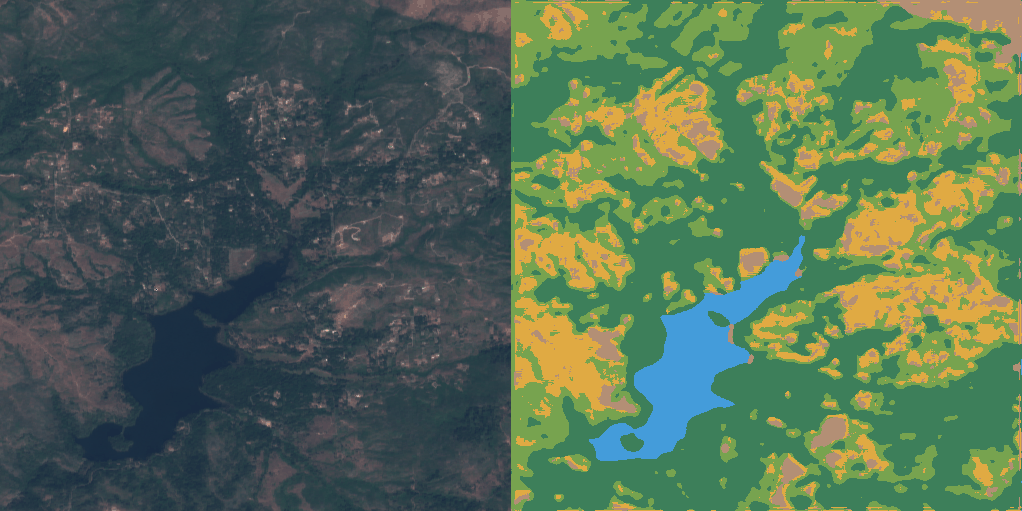

In [ ]:
import os
import imageio
from IPython.display import Image

def land_cover_change_gif(sentinel2_images: np.ndarray, landcover_images: np.ndarray):
  display_legend()

  frames = np.concatenate([sentinel2_images, landcover_images], axis=2)
  imageio.mimwrite('landcover-change.gif', frames, duration=1)
  return Image(open('landcover-change.gif', 'rb').read())

land_cover_change_gif(sentinel2_images, landcover_images)

# Training in Vertex AI

https://cloud.google.com/vertex-ai/docs/training/pre-built-containers

https://pypi.org/project/google-cloud-aiplatform/

https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.CustomTrainingJob

In [ ]:
from google.cloud import aiplatform

epochs = 200

aiplatform.init(project=project, location=location, staging_bucket=bucket)

job = aiplatform.CustomTrainingJob(
    display_name=f"dynamic_world_large_{epochs}", # TODO: simplify
    script_path="train_model.py",
    container_uri="us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest",
)

model = job.run(
    accelerator_type='NVIDIA_TESLA_K80',
    accelerator_count=1,
    args=[
        # TODO: simplify
        f'--training-file=gs://{bucket}/land-cover/training-5000-15.tfrecord.gz',
        f'--validation-file=gs://{bucket}/land-cover/validation-5000-15.tfrecord.gz',
        f'--save-model-to=gs://{bucket}/land-cover/model-large-{epochs}',
        f'--epochs={epochs}',
    ],
    sync=False,
)

https://console.cloud.google.com/vertex-ai/training/training-pipelines

In [ ]:
print(f"input_batch: {input_batch.dtype} {input_batch.shape}")

input_batch: float64 (5, 511, 511, 13)


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(f"gs://{bucket}/land-cover/model-large-200")
probabilities = model.predict(input_batch)

sentinel2_images = render_sentinel2(input_batch)
landcover_images = render_landcover(probabilities)

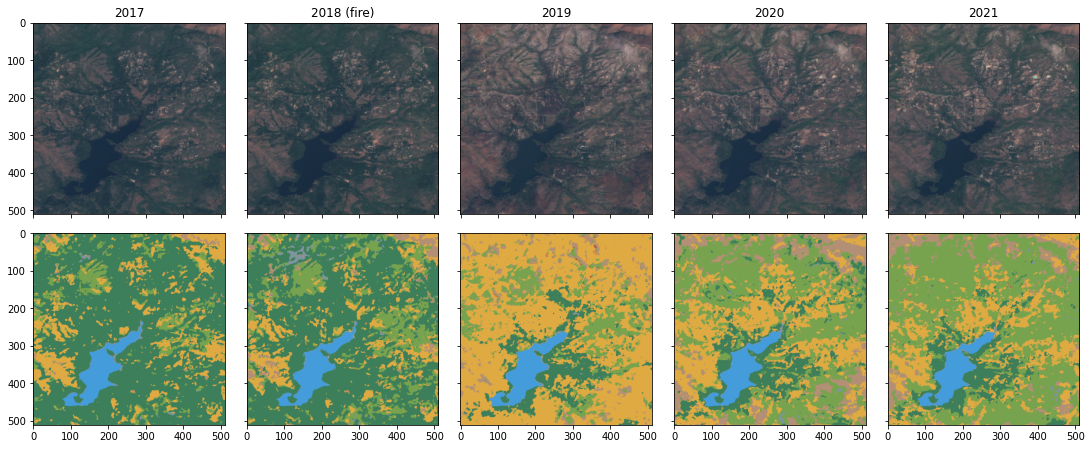

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


In [ ]:
display_land_cover_change(sentinel2_images, landcover_images)

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


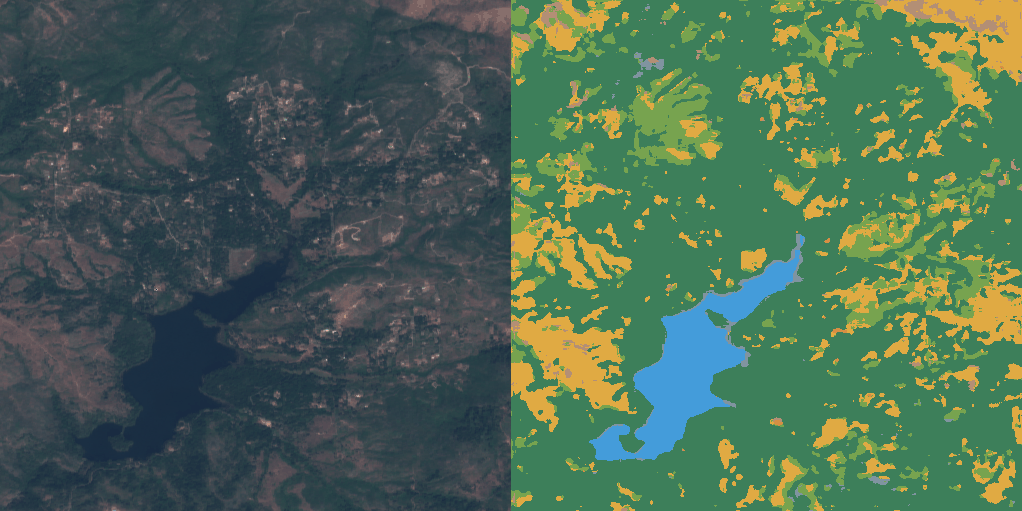

In [ ]:
land_cover_change_gif(sentinel2_images, landcover_images)

# Predictions from Cloud Run

# Predictions from Vertex AI